In [1]:
# !curl -L -o shopping_queries_dataset_examples.parquet https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset/shopping_queries_dataset_examples.parquet
# !curl -L -o shopping_queries_dataset_products.parquet https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset/shopping_queries_dataset_products.parquet

In [2]:
import re
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import norm
from scipy.sparse import save_npz, load_npz
from sentence_transformers import SentenceTransformer
import torch
import pickle
from sklearn.metrics import ndcg_score

In [3]:
products = pd.read_parquet('shopping_queries_dataset_products.parquet')
examples = pd.read_parquet('shopping_queries_dataset_examples.parquet')

In [4]:
df = pd.merge(
    examples, products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id'],
)
df = df[(df['small_version'] == 1) & (df['product_locale'] == 'us')]

print(f'total: {len(df)}')
df.head()

total: 601354


,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
16,16,!awnmower tires without rims,1,B075SCHMPY,us,I,1,1,train,"RamPro 10"" All Purpose Utility Air Tires/Wheel...","<b>About The Ram-Pro All Purpose Utility 10"" A...",✓ The Ram-Pro Ten Inch ready to install Air Ti...,RamPro,10 Inch
17,17,!awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,Please check your existing tire Sidewall for t...,MaxAuto,None
18,18,!awnmower tires without rims,1,B082K7V2GZ,us,I,1,1,train,NEIKO 20601A 14.5 inch Steel Tire Spoon Lever ...,None,[QUALITY]: Hardened Steel-Iron construction wi...,Neiko,None
19,19,!awnmower tires without rims,1,B07P4CF3DP,us,S,1,1,train,2PK 13x5.00-6 13x5.00x6 13x5x6 13x5-6 2PLY Tur...,"Tire Size: 13 x 5.00 - 6 Axle: 3/4"" inside dia...",None,Russo,None
20,20,!awnmower tires without rims,1,B07C1WZG12,us,E,1,1,train,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...,No fuss. Just take off your old assembly and r...,Tire size:15x6.00-6 Ply: 4 Tubeless\n6x4.5 Whe...,Antego Tire & Wheel,Husqvarna Silver


In [5]:
def preprocess_text(text):
    if pd.isna(text) or text is None:
        return ''
    
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s\.,]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


In [6]:
df['query'] = df['query'].map(preprocess_text)
df['product_title'] = df['product_title'].map(preprocess_text)
df['product_description'] = df['product_description'].map(preprocess_text)
df['product_bullet_point'] = df['product_bullet_point'].map(preprocess_text)
df['product_brand'] = df['product_brand'].map(preprocess_text)
df['product_color'] = df['product_color'].map(preprocess_text)

df.head()

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
16,16,awnmower tires without rims,1,B075SCHMPY,us,I,1,1,train,rampro 10 all purpose utility air tires wheels...,b about the ram pro all purpose utility 10 air...,the ram pro ten inch ready to install air tire...,rampro,10 inch
17,17,awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train,maxauto 2 pack 13x5.00 6 2ply turf mower tract...,maxauto 2 pack 13x5.00 6 2ply turf mower tract...,please check your existing tire sidewall for t...,maxauto,
18,18,awnmower tires without rims,1,B082K7V2GZ,us,I,1,1,train,neiko 20601a 14.5 inch steel tire spoon lever ...,,quality hardened steel iron construction with ...,neiko,
19,19,awnmower tires without rims,1,B07P4CF3DP,us,S,1,1,train,2pk 13x5.00 6 13x5.00x6 13x5x6 13x5 6 2ply tur...,tire size 13 x 5.00 6 axle 3 4 inside diameter...,,russo,
20,20,awnmower tires without rims,1,B07C1WZG12,us,E,1,1,train,set of 2 15x6.00 6 husqvarna poulan tire wheel...,no fuss. just take off your old assembly and r...,tire size 15x6.00 6 ply 4 tubeless 6x4.5 wheel...,antego tire wheel,husqvarna silver


In [7]:
sample = df[df['esci_label'] == 'E'].iloc[100]
print(sample['query'])
print(f'-' * 30)
print(sample['product_title'])
print(f'-' * 30)
print(sample['product_brand'])
print(f'-' * 30)
print(sample['product_description'])
print(f'-' * 30)
print(sample['product_bullet_point'])
print(f'-' * 30)
print(sample['esci_label'])

1 black natural hair dye without ammonia or peroxide
------------------------------
hair color for all by discovery naturals natural hair dye for men women i 100 natural chemical free pure hair beard color, midnight natural black
------------------------------
discovery naturals
------------------------------
no burning, itching, or rash hair color for all natural hair dye is made from all natural, organic, and vegan ingredients that are actually good for your hair how it works natural hair dye coats the hair shaft so it always looks natural and translucent, especially in the sun your hair will be stronger, healthier, and more manageable with tons of shine and bounce this natural formula will smooth split ends and cleanse the scalp, promoting hair growth. our easy 3 step method means no complicated mixing of multiple powders and herbs. we have created the perfect blend you simply add water, mix, and apply the dye use as often as needed to touch up your color or cover your gray, even we

In [8]:
unique_query_ids = df['query_id'].unique()
unique_product_ids = df['product_id'].unique()
unique_brands = df['product_brand'].unique()
unique_colors = df['product_color'].unique()

print(f'unique_query_ids: {len(unique_query_ids)}')
print(f'unique_product_ids: {len(unique_product_ids)}')
print(f'unique_brands: {len(unique_brands)}')
print(f'unique_colors: {len(unique_colors)}')

unique_query_ids: 29844
unique_product_ids: 482105
unique_brands: 115950
unique_colors: 73572


In [9]:
def train_tfidf_vectorizer():
    corpus = (
        df['query'].tolist() + df['product_title'].tolist() + df['product_description'].tolist() +
        df['product_bullet_point'].tolist() + df['product_brand'].tolist() + df['product_color'].tolist()
    )
        
    vectorizer = TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=2,
        max_df=0.95
    )

    vectorizer.fit(corpus)

    return vectorizer

vectorizer_save_path = './tfidf_vectorizer.pkl'
if os.path.exists(vectorizer_save_path):
    with open(vectorizer_save_path, 'rb') as f:
        vectorizer = pickle.load(f)
else:
    vectorizer = train_tfidf_vectorizer()
    with open(vectorizer_save_path, 'wb') as f:
        pickle.dump(vectorizer, f)

In [10]:
def load_or_create_tfidf_vectors(vector_name: str, data: list):
    if not os.path.isdir('./vectors'):
        os.makedirs('./vectors')

    file_path = f'./vectors/{vector_name}_vectors.npz'
    
    if os.path.exists(file_path):
        print(f'Load {vector_name} vectors')
        vectors = load_npz(file_path)
    else:
        print(f'Calculate {vector_name} vectors')
        vectors = vectorizer.transform(data)
        save_npz(file_path, vectors)
        
    return vectors

    
def load_or_create_semantic_vectors(model, vector_name, data):
    if not os.path.isdir('./vectors'):
        os.makedirs('./vectors')

    file_path = f'./vectors/{vector_name}_embeddings.npy'
    
    if os.path.exists(file_path):
        print(f'Load {vector_name} embeddings')
        embeddings = np.load(file_path)
    else:
        print(f'Calculate {vector_name} embeddings')
        embeddings = model.encode(data, convert_to_numpy=True, batch_size=128)
        np.save(file_path, embeddings)
        
    return embeddings

def calculate_similarity_csr(vectors1, vectors2):
    norms1 = norm(vectors1, axis=1)
    norms2 = norm(vectors2, axis=1)

    dot_products = np.asarray(vectors1.multiply(vectors2).sum(axis=1)).flatten()
    norm_products = norms1 * norms2

    similarities = np.zeros(vectors1.shape[0]) 
    valid_indices = norm_products > 1e-9 

    similarities[valid_indices] = dot_products[valid_indices] / norm_products[valid_indices]
    return similarities.tolist()

def calculate_jaccard_similarity(text1, text2):
    tokens1 = set(text1.lower().split())
    tokens2 = set(text2.lower().split())

    intersection = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)

    return len(intersection) / len(union) if union else 0.0

def calculate_similarity_numpy(embeddings1, embeddings2):
    dot_products = np.sum(embeddings1 * embeddings2, axis=1)
    norms1 = np.linalg.norm(embeddings1, axis=1)
    norms2 = np.linalg.norm(embeddings2, axis=1)
    similarities = dot_products / (norms1 * norms2 + 1e-8)
    return similarities
    

In [11]:
'''
feature engineering
'''

features_df = df.copy()

features_df['query_length'] = features_df['query'].str.len()
features_df['query_count'] = features_df.groupby('query_id')['query'].transform('count')
features_df['product_count'] = features_df.groupby('product_id')['query_id'].transform('count')
features_df['title_length'] = features_df['product_title'].fillna('').str.len()
features_df['query_in_title'] = features_df.apply(lambda x: 1 if str(x['query']).lower() in str(x['product_title']).lower() else 0, axis=1)
features_df['brand_in_query'] = features_df.apply(lambda x: 1 if str(x['product_brand']).lower() in str(x['query']).lower() else 0, axis=1)
features_df['color_in_query'] = features_df.apply(lambda x: 1 if str(x['product_color']).lower() in str(x['query']).lower() else 0, axis=1)

# tfidf similarity features
print(f'Calculating tfidf similarities..')

query_vectors = load_or_create_tfidf_vectors('query', features_df['query'].tolist())

title_vectors = load_or_create_tfidf_vectors('title', features_df['product_title'].tolist())
features_df['query_title_tfidf'] = calculate_similarity_csr(query_vectors, title_vectors)
del title_vectors

description_vectors = load_or_create_tfidf_vectors('description', features_df['product_description'].tolist())
features_df['query_description_tfidf'] = calculate_similarity_csr(query_vectors, description_vectors)
del description_vectors

bullet_point_vectors = load_or_create_tfidf_vectors('bullet_point', features_df['product_bullet_point'].tolist())
features_df['query_bullet_point_tfidf'] = calculate_similarity_csr(query_vectors, bullet_point_vectors)
del bullet_point_vectors

brand_vectors = load_or_create_tfidf_vectors('brand', features_df['product_brand'].tolist())
features_df['query_brand_tfidf'] = calculate_similarity_csr(query_vectors, brand_vectors)
del brand_vectors

color_vectors = load_or_create_tfidf_vectors('color', features_df['product_color'].tolist())
features_df['query_color_tfidf'] = calculate_similarity_csr(query_vectors, color_vectors)
del color_vectors

del query_vectors


# jaccard similarity features
print(f'Calculating jacaard similarities..')
features_df['query_title_jaccard'] = features_df.apply(lambda x: calculate_jaccard_similarity(x['query'], x['product_title']), axis=1)
features_df['query_description_jaccard'] = features_df.apply(lambda x: calculate_jaccard_similarity(x['query'], x['product_description']), axis=1)
features_df['query_bullet_point_jaccard'] = features_df.apply(lambda x: calculate_jaccard_similarity(x['query'], x['product_bullet_point']), axis=1)
features_df['query_brand_jaccard'] = features_df.apply(lambda x: calculate_jaccard_similarity(x['query'], x['product_brand']), axis=1)
features_df['query_color_jaccard'] = features_df.apply(lambda x: calculate_jaccard_similarity(x['query'], x['product_color']), axis=1)

# semantic similarity features
print(f'Calculating semantic similarities..')
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
print(f'device: {device}')

model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

query_embeddings = load_or_create_semantic_vectors(model, 'query', features_df['query'].tolist())

title_embeddings = load_or_create_semantic_vectors(model, 'title', features_df['product_title'].tolist())
features_df['query_title_semantic'] = calculate_similarity_numpy(query_embeddings, title_embeddings)
del title_embeddings

description_embeddings = load_or_create_semantic_vectors(model, 'description', features_df['product_description'].tolist())
features_df['query_description_semantic'] = calculate_similarity_numpy(query_embeddings, description_embeddings)
del description_embeddings

bullet_point_embeddings = load_or_create_semantic_vectors(model, 'bullet_point', features_df['product_bullet_point'].tolist())
features_df['query_bullet_point_semantic'] = calculate_similarity_numpy(query_embeddings, bullet_point_embeddings)
del bullet_point_embeddings

# brand_embeddings = load_or_create_semantic_vectors(model, 'brand', features_df['product_brand'].tolist())
# features_df['query_brand_semantic'] = calculate_similarity_numpy(query_embeddings, brand_embeddings)
# del brand_embeddings

# color_embeddings = load_or_create_semantic_vectors(model, 'color', features_df['product_color'].tolist())
# features_df['query_color_semantic'] = calculate_similarity_numpy(query_embeddings, color_embeddings)
# del color_embeddings

del query_embeddings
del model

label_mapping = {
    'E': 4,  # Exact match
    'S': 3,  # Substitute
    'C': 2,  # Complement
    'I': 1   # Irrelevant
}
features_df['relevance'] = features_df['esci_label'].apply(lambda x: label_mapping.get(x, 1))

Calculating tfidf similarities..
Load query vectors
Load title vectors
Load description vectors
Load bullet_point vectors
Load brand vectors
Load color vectors
Calculating jacaard similarities..
Calculating semantic similarities..
device: mps
Load query embeddings
Load title embeddings
Load description embeddings
Load bullet_point embeddings


In [12]:
numeric_features = [
    'query_length', 'query_count', 'product_count', 'title_length',
    'query_title_tfidf', 'query_description_tfidf', 'query_bullet_point_tfidf', 'query_brand_tfidf', 'query_color_tfidf',
    'query_title_jaccard', 'query_description_jaccard', 'query_bullet_point_jaccard', 'query_brand_jaccard', 'query_color_jaccard',
    'query_title_semantic', 'query_description_semantic', 'query_bullet_point_semantic',
]

categorical_features = [
    'query_in_title', 'brand_in_query', 'color_in_query',
]

features = numeric_features + categorical_features

# features_df = features_df[
#     ['query_id', 'query', 'product_id', 'relevance', 'split'] + features
# ]

features_df_train = features_df[features_df['split'] == 'train'].drop(labels=['split'], axis=1)
features_df_test = features_df[features_df['split'] == 'test'].drop(labels=['split'], axis=1)

features_df_train = features_df_train.sort_values('query_id').reset_index(drop=True)
features_df_test = features_df_test.sort_values('query_id').reset_index(drop=True)

# train/validation split
train_query_ids = features_df_train['query_id'].unique()
np.random.shuffle(train_query_ids)
split_index = int(len(train_query_ids) * 0.9)

train_ids = train_query_ids[:split_index]
val_ids = train_query_ids[split_index:]

features_df_val = features_df_train[features_df_train['query_id'].isin(val_ids)]
features_df_train = features_df_train[features_df_train['query_id'].isin(train_ids)]

print(f'train: {len(features_df_train)}')
print(f'val: {len(features_df_val)}')
print(f'test: {len(features_df_test)}')

features_df_train.head()

train: 377292
val: 42361
test: 181701


,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,product_title,product_description,...,query_color_tfidf,query_title_jaccard,query_description_jaccard,query_bullet_point_jaccard,query_brand_jaccard,query_color_jaccard,query_title_semantic,query_description_semantic,query_bullet_point_semantic,relevance
0,16,awnmower tires without rims,1,B075SCHMPY,us,I,1,1,rampro 10 all purpose utility air tires wheels...,b about the ram pro all purpose utility 10 air...,...,0.0,0.043478,0.011628,0.007576,0.0,0.0,0.477928,0.304581,0.337482,1
1,31,awnmower tires without rims,1,B01H3KC5U2,us,I,1,1,craftsman 532403111 mower front drive wheels p...,2 ayp craftsman mower front drive wheels for 1...,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.340683,0.254729,0.369100,1
2,30,awnmower tires without rims,1,B00004RA3F,us,I,1,1,american lawn mower company 1204 14 14 inch 4 ...,,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.236484,0.049802,0.227165,1
3,29,awnmower tires without rims,1,B0018TWDOI,us,E,1,1,oregon 72 107 universal wheel 7x150 diamond pl...,,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.334069,0.049802,0.185634,4
4,28,awnmower tires without rims,1,B005O5Y3QI,us,E,1,1,carlisle turf saver lawn garden tire 15x6 6 a,,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.467657,0.049802,0.120387,4


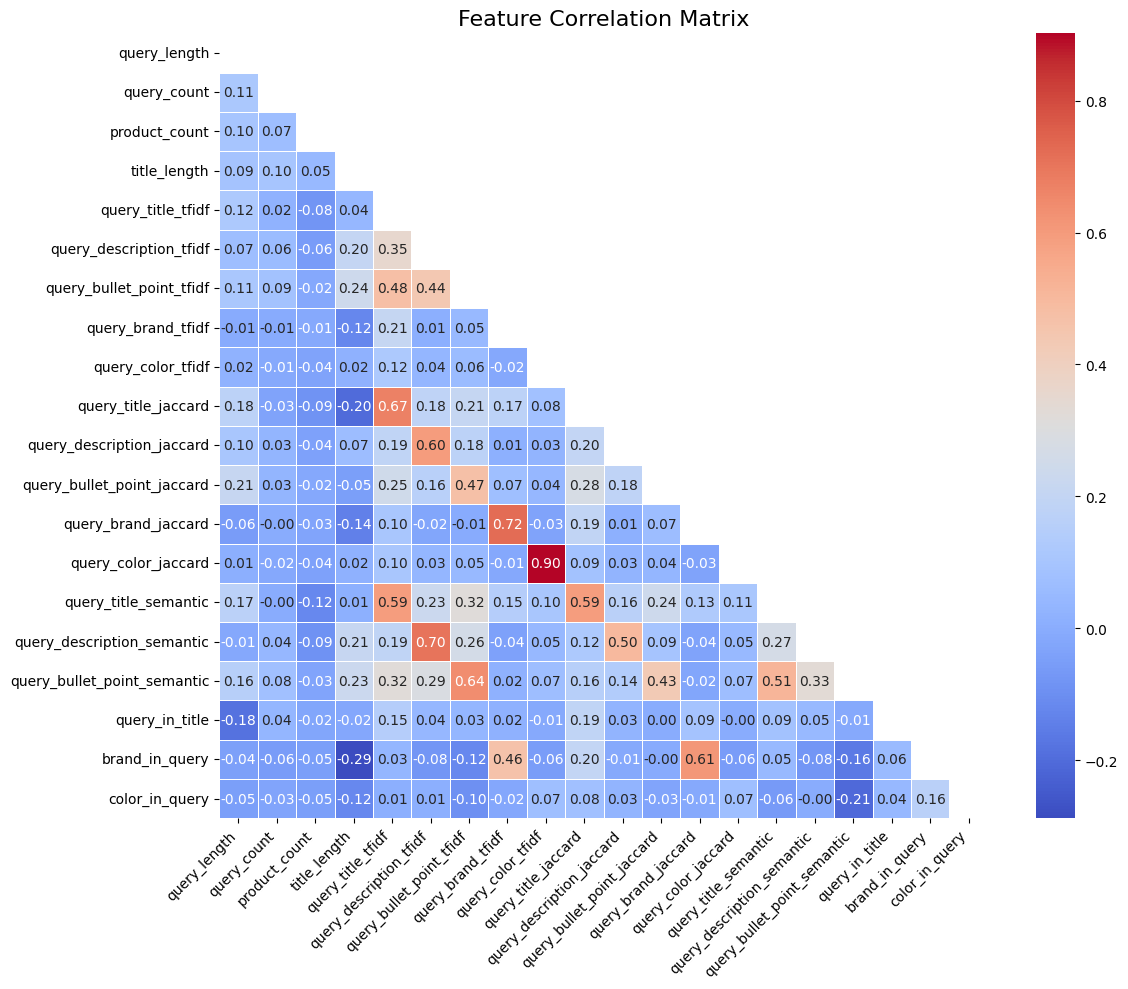

In [13]:
sample_df = features_df[features].sample(n=100000, random_state=42)
corr_matrix = sample_df.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

In [16]:
scaler = StandardScaler().fit(features_df_train[numeric_features].values)

def prepare_lgbm_dataset(features_df):
    query_groups = features_df.groupby('query_id').size().values

    X_numeric = features_df[numeric_features].values
    X_numeric = scaler.transform(X_numeric)
    X_categorical = features_df[categorical_features].values

    X = np.hstack([X_numeric, X_categorical])
    y = features_df['relevance'].values

    return X, y, query_groups

In [17]:
X_train, y_train, groups_train = prepare_lgbm_dataset(features_df_train)
X_val, y_val, groups_val = prepare_lgbm_dataset(features_df_val)
X_test, y_test, groups_test = prepare_lgbm_dataset(features_df_test)

In [18]:
model = lgb.LGBMRanker(
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.1,
    objective='lambdarank',
    random_state=42,
)

categorical_features_indices = [i for i in range(len(numeric_features), len(features))]
model.fit(
    X=X_train,
    y=y_train,
    group=groups_train,
    eval_metric='ndcg',
    eval_set=[(X_val, y_val)],
    eval_group=[groups_val],
    categorical_feature=categorical_features_indices,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(10)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3333
[LightGBM] [Info] Number of data points in the train set: 377292, number of used features: 20
Training until validation scores don't improve for 100 rounds
[10]	valid_0's ndcg@1: 0.772204	valid_0's ndcg@2: 0.764063	valid_0's ndcg@3: 0.763577	valid_0's ndcg@4: 0.764873	valid_0's ndcg@5: 0.766501
[20]	valid_0's ndcg@1: 0.775906	valid_0's ndcg@2: 0.768412	valid_0's ndcg@3: 0.766964	valid_0's ndcg@4: 0.768043	valid_0's ndcg@5: 0.770875
[30]	valid_0's ndcg@1: 0.777182	valid_0's ndcg@2: 0.768883	valid_0's ndcg@3: 0.767893	valid_0's ndcg@4: 0.76927	valid_0's ndcg@5: 0.770713
[40]	valid_0's ndcg@1: 0.778459	valid_0's ndcg@2: 0.768949	valid_0's ndcg@3: 0.76783	valid_0's ndcg@4: 0.768629	valid_0's ndcg@5: 0.771565
[50]	valid_0's ndcg@1: 0.7

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


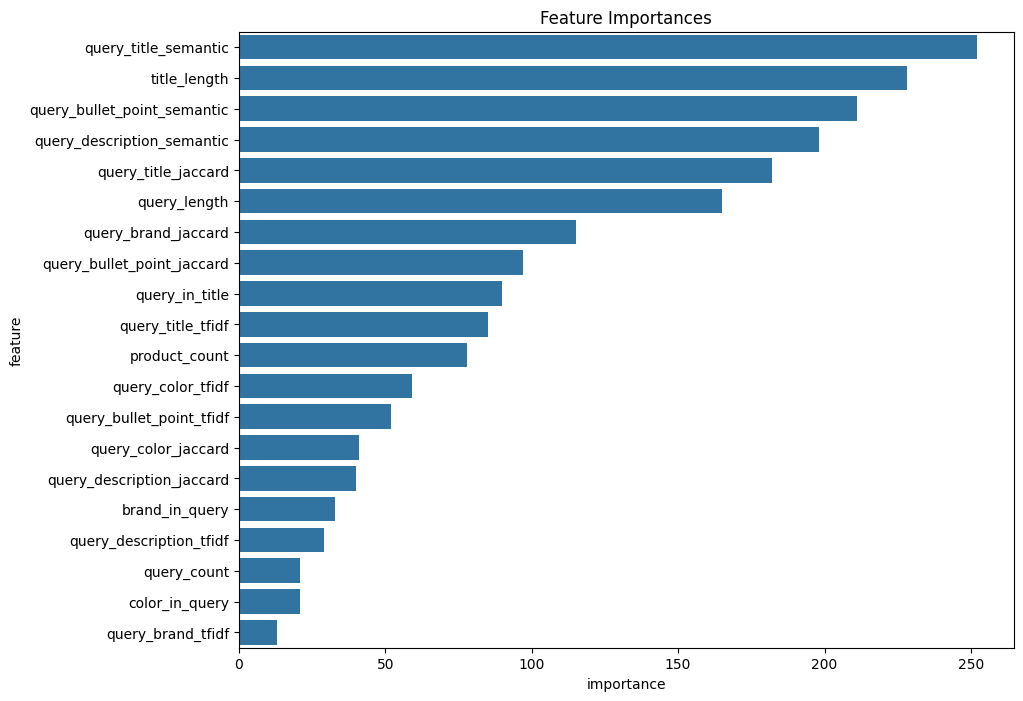

                        feature  importance
14         query_title_semantic         252
3                  title_length         228
16  query_bullet_point_semantic         211
15   query_description_semantic         198
9           query_title_jaccard         182
0                  query_length         165
12          query_brand_jaccard         115
11   query_bullet_point_jaccard          97
17               query_in_title          90
4             query_title_tfidf          85
2                 product_count          78
8             query_color_tfidf          59
6      query_bullet_point_tfidf          52
13          query_color_jaccard          41
10    query_description_jaccard          40
18               brand_in_query          33
5       query_description_tfidf          29
1                   query_count          21
19               color_in_query          21
7             query_brand_tfidf          13


In [19]:
importance_df = pd.DataFrame({
    'feature': features, # 위에서 정의한 feature_columns 사용
    'importance': model.feature_importances_,
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

print(importance_df)

In [20]:
def calculate_ndcg(df, k_values=[1, 3, 5, 10]):
    ndcg_scores = {k: [] for k in k_values}
    
    for _, group in df.groupby('query_id'):
        true_relevance = group['relevance'].values
        pred_scores = group['prediction_score'].values
        
        for k in k_values:
            score = ndcg_score([true_relevance], [pred_scores], k=k)
            ndcg_scores[k].append(score)
            
    avg_ndcg = {
        f'NDCG@{k}': np.mean(scores)
        for k, scores in ndcg_scores.items()
    }

    return avg_ndcg

In [21]:
predictions = model.predict(X_test)
features_df_test['prediction_score'] = predictions

ndcg_scores = calculate_ndcg(features_df_test)
for metric, score in ndcg_scores.items():
    print(f"{metric}: {score:.4f}")

/Users/vegeta/.pyenv/versions/3.12.3/envs/learning-to-rank/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


NDCG@1: 0.8714
NDCG@3: 0.8669
NDCG@5: 0.8698
NDCG@10: 0.8921


In [95]:
sample_query_id = np.random.choice(features_df_test['query_id'])
sample_df = features_df_test[features_df_test['query_id'] == sample_query_id].sort_values(by='prediction_score', ascending=False)
sample_df = sample_df[['query_id', 'query', 'product_title', 'relevance', 'prediction_score']]
sample_df.head(100)

,query_id,query,product_title,relevance,prediction_score
93457,56930,kano kit touch,kano computer kit touch build and code a tablet,4,1.017167
93452,56930,kano kit touch,kano computer kit 2016 edition,3,0.546649
93451,56930,kano kit touch,kano motion sensor kit learn to code with move...,4,0.533567
93447,56930,kano kit touch,kano build your own computer screen kit,3,0.340654
93449,56930,kano kit touch,kano pixel kit learn to code with light,3,0.331822
93453,56930,kano kit touch,kano harry potter coding kit build a wand. lea...,3,0.102047
93454,56930,kano kit touch,hermitshell hard travel case for kano computer...,2,-0.153446
93455,56930,kano kit touch,kano star wars the force coding kit explore th...,3,-0.331333
93456,56930,kano kit touch,kano disney frozen 2 coding kit awaken the ele...,3,-0.374392
93448,56930,kano kit touch,kano english subtitled,1,-0.395256
